<a href="https://colab.research.google.com/github/Ludvins/2024_PAC-Chernoff-Bound/blob/main/Figure6and7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!sudo apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm

from google.colab import files
import pickle

In [3]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [4]:
!nvidia-smi

Wed Aug 14 12:03:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Set-Up

In [5]:
# LENET parameters
RANDOM_SEED = 2147483647
LEARNING_RATE = 0.01 #0.0001 for MLP
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 2000000
BATCH_SIZE = 200
BATCH_SIZE_TEST = 1000


IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2.
weight_decay = 0.01

do_train = False

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [7]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")



transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             #torchvision.transforms.CenterCrop(IMG_SIZE),
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])



In [8]:
!nvidia-smi

Wed Aug 14 12:03:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
train_dataset = datasets.CIFAR10(root='cifar_data',
                                train=True,
                                transform=transforms,
                                download=True)

test_dataset = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms)


100%|██████████| 170498071/170498071 [00:12<00:00, 14053244.61it/s]


Extracting cifar_data/cifar-10-python.tar.gz to cifar_data


In [10]:
train_dataset = torch.utils.data.Subset(train_dataset, list(range(0, SUBSET_SIZE)))
test_dataset = torch.utils.data.Subset(test_dataset, list(range(0, TEST_SUBSET_SIZE)))

In [11]:
test_loader_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE_TEST,
                          shuffle=False)

# Training

In [12]:
#Download https://github.com/Ludvins/2024_PAC-Chernoff-Bound/blob/main/utils.py and import it

!wget https://raw.githubusercontent.com/Ludvins/2024_PAC-Chernoff-Bound/main/utils.py
from utils import *

--2024-08-14 12:04:03--  https://raw.githubusercontent.com/Ludvins/2024_PAC-Chernoff-Bound/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8553 (8.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   8.35K  --.-KB/s    in 0.001s  

2024-08-14 12:04:03 (8.64 MB/s) - ‘utils.py’ saved [8553/8553]



In [13]:
ks = np.arange(0.2, 5, step = 0.1)

In [14]:
ks

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
       4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])

In [15]:
models = [createmodel(k).to(device) for k in ks]

In [16]:
n_params = []
for model in models:
  n = 0
  for parameter in model.parameters():
    n += parameter.flatten().size(0)
  n_params.append(n)

In [17]:
jet = plt.cm.get_cmap('Dark2')

<ipython-input-17-92d3b638b2ea>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('Dark2')


In [18]:
labels = ["ConvNN-"+str(p//1000)+"k" for p in n_params]
labels

['ConvNN-4k',
 'ConvNN-7k',
 'ConvNN-12k',
 'ConvNN-18k',
 'ConvNN-24k',
 'ConvNN-32k',
 'ConvNN-39k',
 'ConvNN-50k',
 'ConvNN-62k',
 'ConvNN-71k',
 'ConvNN-85k',
 'ConvNN-96k',
 'ConvNN-112k',
 'ConvNN-130k',
 'ConvNN-143k',
 'ConvNN-163k',
 'ConvNN-178k',
 'ConvNN-200k',
 'ConvNN-223k',
 'ConvNN-241k',
 'ConvNN-266k',
 'ConvNN-285k',
 'ConvNN-313k',
 'ConvNN-342k',
 'ConvNN-363k',
 'ConvNN-395k',
 'ConvNN-417k',
 'ConvNN-451k',
 'ConvNN-486k',
 'ConvNN-511k',
 'ConvNN-548k',
 'ConvNN-575k',
 'ConvNN-614k',
 'ConvNN-655k',
 'ConvNN-684k',
 'ConvNN-727k',
 'ConvNN-758k',
 'ConvNN-803k',
 'ConvNN-850k',
 'ConvNN-883k',
 'ConvNN-931k',
 'ConvNN-966k',
 'ConvNN-1017k',
 'ConvNN-1069k',
 'ConvNN-1106k',
 'ConvNN-1161k',
 'ConvNN-1199k',
 'ConvNN-1256k']

In [19]:
if do_train:
  for i in range(len(models)):
    g_cuda = torch.Generator(device='cpu')
    g_cuda.manual_seed(RANDOM_SEED)
    loader = torch.utils.data.DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            generator=g_cuda,
                            shuffle=True)
    train(device, models[i], loader, criterion, LEARNING_RATE, N_ITERS)
    with open(f'{labels[i]}_pickle', 'wb') as handle:
      pickle.dump(models[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
models = []
for label in labels:
  with open(f'drive/MyDrive/models/{label}.pickle', 'rb') as handle:
    models.append(pickle.load(handle))

In [21]:
train_loss = []
test_loss = []
for i in range(len(models)):
  loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
  train_loss.append(eval(device, models[i],  loader, criterion)[2])
  test_loss.append(eval(device, models[i],  test_loader_batch, criterion)[2])

In [22]:
print(train_loss)

[1.540357985973358, 1.3855963797569275, 1.2105873956680298, 1.0566950323581696, 0.9398591833114625, 0.840426557302475, 0.7766044471263885, 0.6692623708248139, 0.5666834120750427, 0.5367131805419922, 0.4197220315933228, 0.3779823422431946, 0.28562557154893875, 0.23443520760536193, 0.17356260481476785, 0.12491377687454223, 0.09689463415741921, 0.05314751090854406, 0.04939759133756161, 0.04676807145774364, 0.03407826977223158, 0.026232332415878773, 0.017375478569418193, 0.017015967596322297, 0.013520042579621076, 0.010135718278586864, 0.010081145152449608, 0.009822017408907414, 0.009581025689840317, 0.009611428543925285, 0.009355960419401526, 0.009398717848584056, 0.00925325240381062, 0.00921416625380516, 0.009144551610574127, 0.009194117553532123, 0.009231804763898253, 0.008984347999095917, 0.008950068701058626, 0.009056871829554438, 0.008669799409806729, 0.009027865329757332, 0.00914384556002915, 0.008811500450596213, 0.008709088452160358, 0.008922212213277816, 0.008948181373998523, 0.0

In [23]:
print(test_loss)

[1.5686882734298706, 1.4497804284095763, 1.3224125862121583, 1.2335437536239624, 1.1930899262428283, 1.1716919779777526, 1.2250527381896972, 1.1940154314041138, 1.1756273746490478, 1.2518911004066466, 1.3532754540443421, 1.4069743156433105, 1.4421390771865845, 1.4590741395950317, 1.692452335357666, 1.819783055782318, 1.9727694153785706, 2.15237557888031, 2.0705260038375854, 2.0887301564216614, 2.155430996417999, 2.1820918321609497, 2.2027193784713743, 2.0835948944091798, 2.1855706214904784, 2.287843108177185, 2.193456935882568, 2.257759523391724, 2.0890161991119385, 2.1722748041152955, 2.104975473880768, 2.0886283993721007, 2.108360242843628, 1.9145919561386109, 2.008163583278656, 1.8492913246154785, 1.947775399684906, 1.9289663553237915, 1.875605833530426, 1.8641416311264039, 1.8344759106636048, 1.803682768344879, 1.761367177963257, 1.8397862553596496, 1.8358343362808227, 1.7257910132408143, 1.7456877946853637, 1.703177547454834]


In [24]:

def aux_inv_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

    while (high - low) > epsilon:
        mid1 = low + (high - low) / 3
        mid2 = high - (high - low) / 3
        inv1 = eval_inverse_rate_at_lambda(log_p, mid1, s_value)
        inv2 = eval_inverse_rate_at_lambda(log_p, mid2, s_value)
        if inv1 < inv2:
            high = mid2
        else:
            low = mid1
    # Return the midpoint of the final range
    mid = (low + high) / 2
    inv = eval_inverse_rate_at_lambda(log_p, mid, s_value)

    return [
        inv.detach().cpu().numpy(),
        mid.detach().cpu().numpy(),
        (inv*mid - s_value).detach().cpu().numpy(),
    ]

def eval_inverse_rate_at_lambda(log_p, lamb, s_value):
    jensen_val = (
        torch.logsumexp(lamb * log_p, -1)
        - torch.log(torch.tensor(log_p.shape[-1], device=device))
    ).mean(0)

    # aux_tensor = torch.log(torch.tensor(10/0.05, device=device))
    # jensen_val = torch.log(torch.exp(jensen_val) + torch.sqrt(0.5*aux_tensor/torch.tensor(log_p.shape[-1], device=device))).mean(0)
    return (s_value + jensen_val)/lamb - torch.mean(log_p)


def inverse_rate_function(model, s_value):

  min_lamb=torch.tensor(0).to(device)
  max_lamb=torch.tensor(100000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, test_loader_batch)
  return aux_inv_rate_function_TernarySearch(log_p, s_value, min_lamb, max_lamb, 0.01)

In [25]:
bounds = np.array([inverse_rate_function(models[i], 1/len(train_dataset) * (n_params[i] * 32 - np.log2(0.05)))[0] for i in range(len(models))])

In [26]:
bounds = bounds + train_loss

In [27]:
latex_format()

In [28]:
N = 7
train_loss_ = *([train_loss[0]]*(N//2)), *train_loss, *([train_loss[-1]]*(N//2))
test_loss_ = *([test_loss[0]]*(N//2)), *test_loss, *([test_loss[-1]]*(N//2))
bounds_ = *([bounds[0]]*(N//2)), *bounds, *([bounds[-1]]*(N//2))


train_loss_ = np.convolve(train_loss_, np.ones(N)/N, mode = "valid")
test_loss_ = np.convolve(test_loss_, np.ones(N)/N, mode = "valid")
bounds_ = np.convolve(bounds_, np.ones(N)/N, mode = "valid")

In [29]:
plt.rcParams['figure.figsize'] = (16, 8)

24


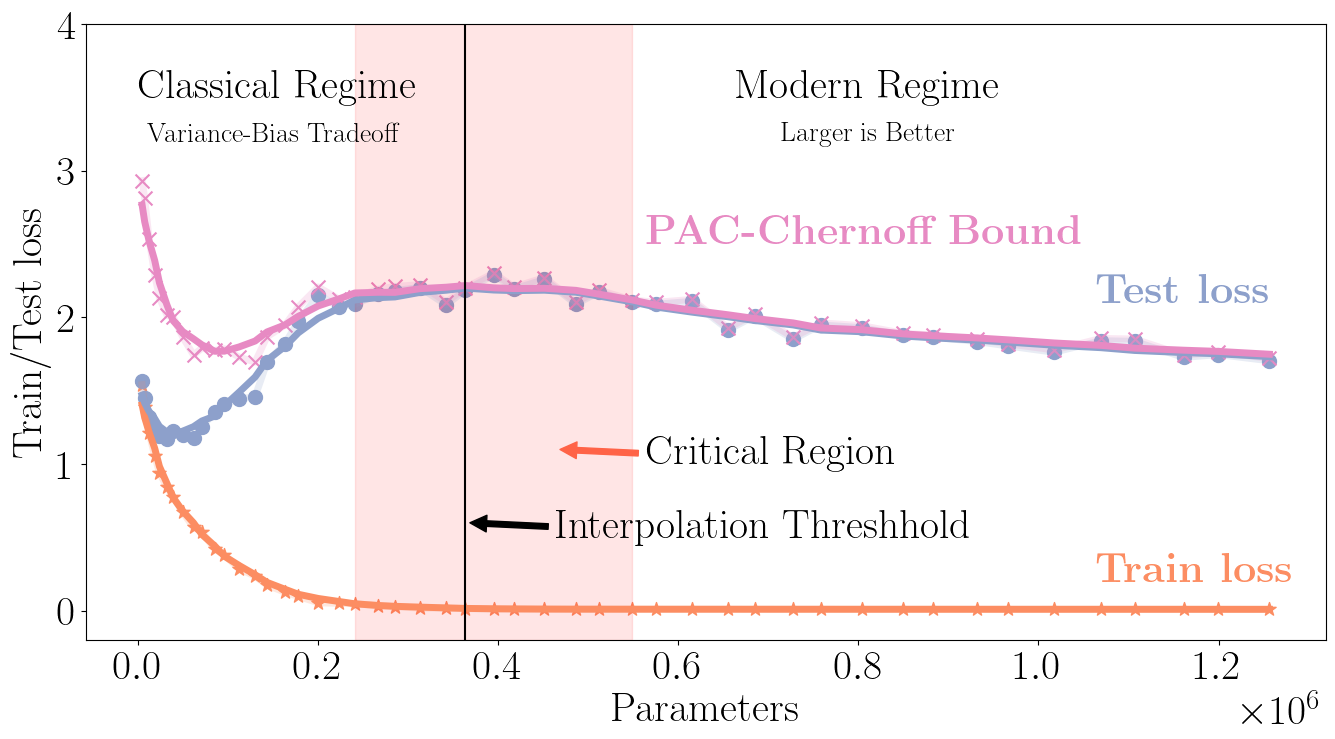

In [30]:
jet = plt.colormaps["Set2"]
lw = 5
plt.plot(n_params, train_loss, linewidth = lw, color = jet(1), alpha = 0.2)
plt.plot(n_params, test_loss, linewidth = lw, color = jet(2), alpha = 0.2)
plt.plot(n_params, bounds, linewidth = lw, color = jet(3), alpha = 0.2)

plt.plot(n_params, train_loss_,  linewidth =lw, color = jet(1))
plt.plot(n_params, test_loss_, linewidth = lw, color = jet(2))
plt.plot(n_params, bounds_, linewidth = lw, color = jet(3))


plt.scatter(n_params, train_loss, marker = "*", label = "Train loss", color = jet(1), s = 100)
plt.scatter(n_params, test_loss, marker = "o", label = "Test loss", color = jet(2), s = 100)
plt.scatter(n_params, bounds, marker = "x", label = "Bound", color = jet(3), s = 100)


max_test = np.argmax(test_loss_)
mask = np.isclose(test_loss_, test_loss_[max_test], 0.05)
min_region = np.where(mask == True)[0][0]
max_region = np.where(mask == True)[0][-1]

print(max_test)
plt.annotate("Classical Regime", xy = (0, 3.5))
plt.annotate("Variance-Bias Tradeoff", xy = (10000, 3.2), fontsize = 20)

plt.annotate("Modern Regime",xy = (n_params[max_region]+200000, 3.5), xytext = (n_params[max_test]+300000, 3.5))
plt.annotate("Larger is Better", xy = (n_params[max_test]+350000, 3.2), fontsize = 20)

plt.annotate("Interpolation Threshhold",xy = (n_params[max_test], 0.6), xytext = (n_params[max_test]+100000, 0.5), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("Critical Region",xy = (n_params[max_test]+100000, 1.1), xytext = (n_params[max_test]+200000, 1), arrowprops=dict(color='tomato', shrink=0.05))


plt.annotate(r"\textbf{Train loss}",xy = (n_params[max_test]+500000, 0.2), xytext = (n_params[max_test]+700000, 0.2), color = jet(1))
plt.annotate(r"\textbf{Test loss}",xy = (n_params[max_test]+500000, 2.1), xytext = (n_params[max_test]+700000, 2.1), color = jet(2))
plt.annotate(r"\textbf{PAC-Chernoff Bound}",xy = (n_params[max_test]+500000, 2.1), xytext = (n_params[max_test]+200000, 2.5), color = jet(3))


plt.axvspan(n_params[min_region], n_params[max_region], alpha=0.1, color='red')
plt.vlines(n_params[max_test], ymin = -0.2, ymax =4, color = "black")
plt.ylim(-0.2, 4)
plt.ylabel("Train/Test loss")
plt.xlabel("Parameters")
plt.savefig("double_descent.pdf", format = "pdf",bbox_inches='tight')



# Figure 4: Jensen-Gap Functions Evolution

In [31]:
indexes = np.arange(len(n_params), step = 5)
indexes

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [32]:
for i in indexes:
  print(labels[i])
  loader = torch.utils.data.DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
  print("Train", eval(device, models[i],  loader, criterion))
  print("Test", eval(device, models[i],  test_loader_batch, criterion))
  print("Bound ", bounds[i])

ConvNN-4k
Train (21941, 50000, 1.5403579745292664)
Test (4274, 10000, 1.5686882734298706)
Bound  2.9308003414224046
ConvNN-32k
Train (35421, 50000, 0.8404265673160553)
Test (5986, 10000, 1.1716919779777526)
Bound  2.0122325740749964
ConvNN-85k
Train (43345, 50000, 0.41972203397750857)
Test (6273, 10000, 1.3532754540443421)
Bound  1.7735009270279447
ConvNN-163k
Train (48825, 50000, 0.12491377699375153)
Test (6397, 10000, 1.819783055782318)
Bound  1.945720354626202
ConvNN-266k
Train (49922, 50000, 0.03407826992869377)
Test (6519, 10000, 2.155430996417999)
Bound  2.191198250243914
ConvNN-395k
Train (49999, 50000, 0.010135718241333962)
Test (6574, 10000, 2.287843108177185)
Bound  2.3004921266370704
ConvNN-548k
Train (50000, 50000, 0.00935596039518714)
Test (6727, 10000, 2.104975473880768)
Bound  2.1178279827868938
ConvNN-727k
Train (49999, 50000, 0.009194117680191993)
Test (6988, 10000, 1.8492913246154785)
Bound  1.86312653814432
ConvNN-931k
Train (49999, 50000, 0.00866979922913015)
Test (

In [33]:
s_values = np.arange(0, 0.5, 0.01)
lambdas = np.arange(0, 10, 0.01)
Is = []


In [34]:
jensens = [eval_jensen(device, models[i].to(device), lambdas, test_loader_batch) for i in indexes]

In [36]:
def rate_function_BS(device, model, s_value, loader):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  log_p = get_log_p(device, model, loader)
  return aux_rate_function_TernarySearch(device, log_p, s_value, min_lamb, max_lamb, 0.001)


In [37]:
rates = []
s_values = np.arange(0, 0.5, 0.01)

for i in indexes:
  print(i)
  rates.append(np.array([rate_function_BS(device, models[i].to(device), s, test_loader_batch)[0] for s in s_values]))



0
5
10
15
20
25
30
35
40
45


In [39]:
markers = [8, 9, 10, 11, "+", "o", ">"]
colors = [jet(0), jet(1), jet(2), jet(3), jet(4), jet(6)]

In [40]:
plt.rcParams['figure.figsize'] = (16, 7)
fontsize = 30

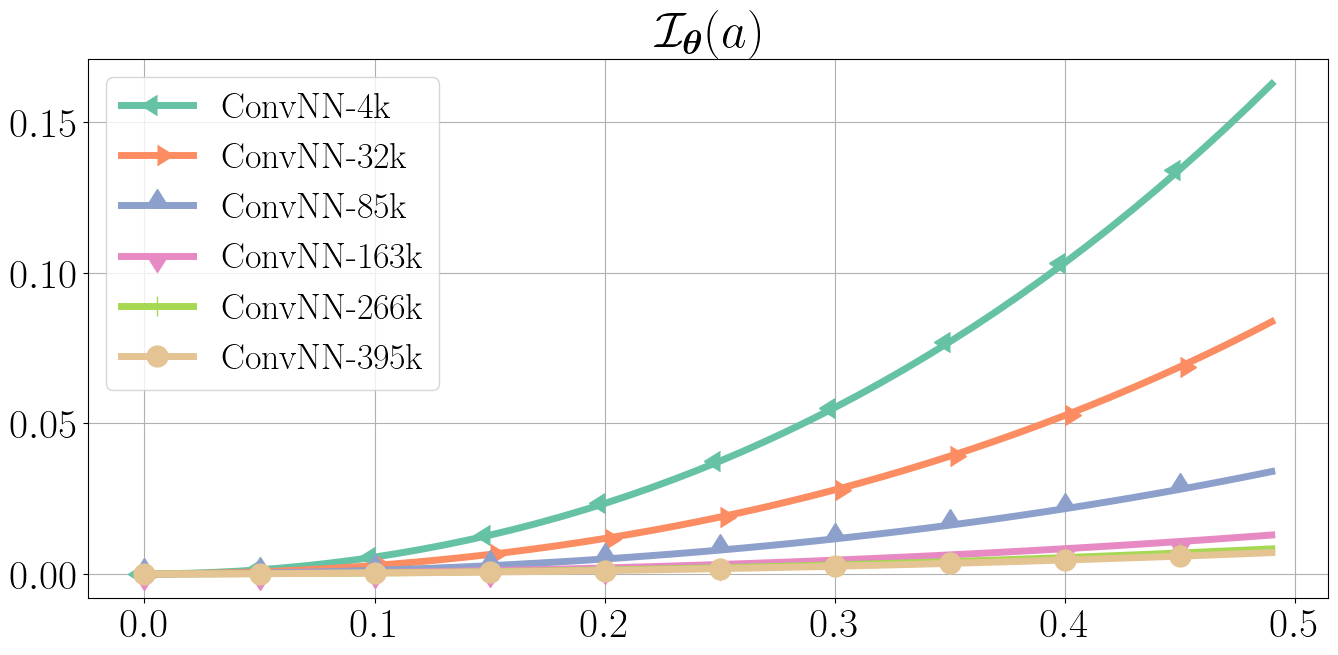

In [41]:
for idx, i in enumerate(indexes[:6]):
  plt.plot(s_values, rates[idx], label=labels[i],linewidth=5, color = colors[idx], marker = markers[idx],  markersize=15, markevery=5)

plt.legend(fontsize=20, prop={'size': 26})
plt.grid()
plt.title(r"$\mathcal{I}_{\bm \theta}(a)$")
plt.savefig("rate_1.pdf", format = "pdf",bbox_inches='tight')
plt.show()

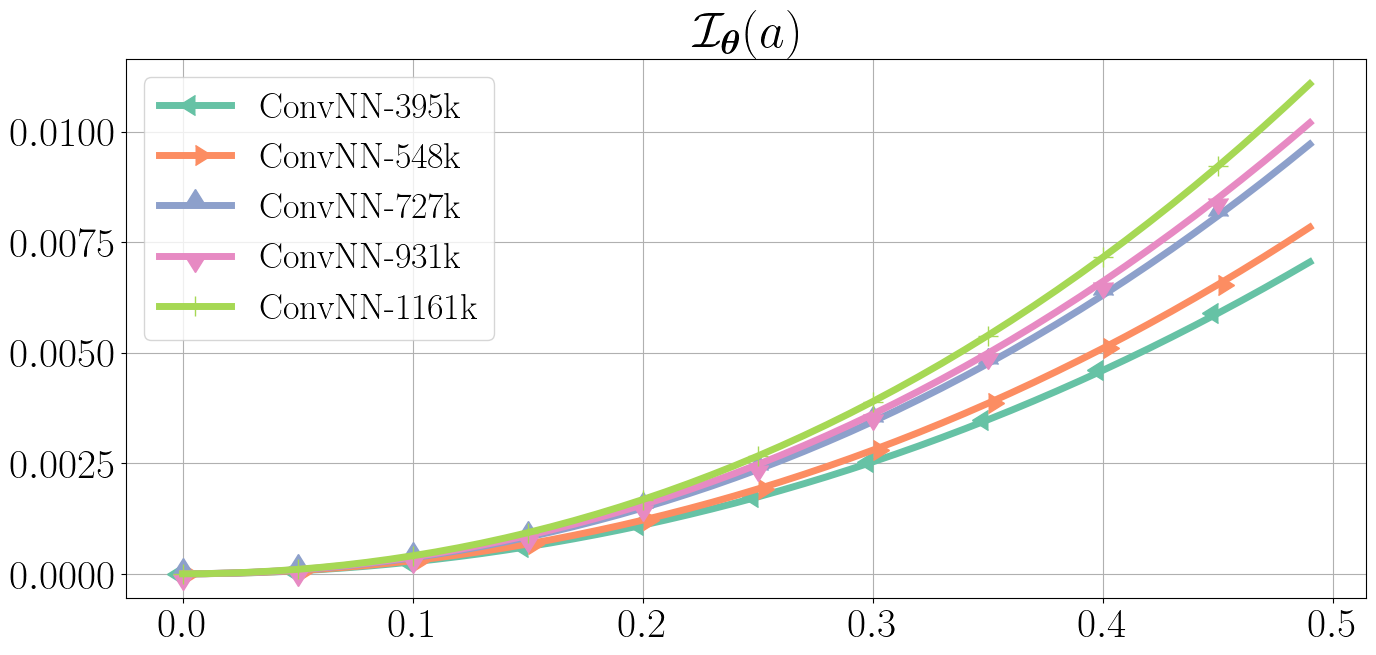

In [42]:
for idx, i in enumerate(indexes[5:]):
  plt.plot(s_values, rates[5+idx], label=labels[i],linewidth=5, color = jet(idx), marker = markers[idx],  markersize=15, markevery=5)

#plt.yticks([0,0.002, 0.005, 0.007, 0.01])

plt.grid()
plt.legend(fontsize=20, prop={'size': 26})
plt.title(r"$\mathcal{I}_{\bm \theta}(a)$")
plt.savefig("rate_2.pdf", format = "pdf",bbox_inches='tight')
plt.show()